# NFL Predictor Model

Hello!! Welcome to my jupyter notebook for milestone 3. In this notebook, I will go through cleaning the data and merging two datasets I plan to use, engineer per-game statistics the model will use, and then implement an ensemble model for some predictions.

## Research Question

Current research question: Can I, using the nflreadpy dataset, reliably predict the outcomes of NFL games before they happen?



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import nflreadpy as nfl
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, StratifiedKFold
# Heads up! You probably will have to open up the terminal in colab and do pip install nflreadpy to get
# the dataset api

## Data and Cleaning

The data in these datasets come cleaned up (for the most part) already, and the columns that aren't clean are not being used for this model, so not much to clean. The real challenge comes from merging. This took the most amount of hours to really learn how to do, I was very confused the whole time but eventually got it to work

The issue? The team stats dataset had two entries per game every week, one for the home and one for the away team. The home and away teams were not denoted by home and away in any way, so I essentially had to make a mask that included info about the team's home/away status and the corresponding game_id, then use that to merge the team_stats into the schedules dataset to get a giant dataset with team stats for both teams from each game.

First step: get the team_stats dataset to have game_ids

(p.s: I realized it would be best to add point diff here as a new feature, but added the point differential rolling and season avgs in the feature engineering section)

In [ ]:
schedules = nfl.load_schedules(seasons=[2000, 2024]).to_pandas()
team_stats = nfl.load_team_stats(seasons=[2000,2024]).to_pandas()

#only using until season 2024, as the schedules and stats datasets contain
# a varied amount of info for upcoming/recently completed games

keys = ['game_id','season','week','game_type','home_team', 'away_team', 'home_score', 'away_score']

schedulesWKeys = schedules[keys].drop_duplicates()

ids = [column for column in schedulesWKeys.columns if column not in ['home_team', 'away_team']]
map = schedulesWKeys.melt(id_vars=ids, value_vars=['home_team', 'away_team'], var_name='side', value_name='team')

map['home_away'] = map['side'].str.replace('_team','', regex=False)

left_keys = ['season', 'week', 'team']
right_keys = ['season', 'week', 'team']

new_ts = team_stats.merge(map, left_on=left_keys, right_on=right_keys, how='inner')

# essentially just check if the team is home or away and put the points for or against in the correct column
new_ts['points_for'] = np.where(new_ts['home_away'].eq('home'),
                                new_ts['home_score'], new_ts['away_score'])
new_ts['points_against'] = np.where(new_ts['home_away'].eq('home'),
                                    new_ts['away_score'], new_ts['home_score'])
new_ts['point_diff'] = new_ts['points_for'] - new_ts['points_against']


print(new_ts)


      season  week team season_type opponent_team  completions  attempts  \
0       2000     1  ARI         REG           NYG           28        49   
1       2000     1  ATL         REG            SF           16        31   
2       2000     1  BAL         REG           PIT           18        32   
3       2000     1  BUF         REG           TEN           13        26   
4       2000     1  CAR         REG           WAS           17        26   
...      ...   ...  ...         ...           ...          ...       ...   
1079    2024    21   KC        POST           BUF           18        26   
1080    2024    21  PHI        POST           WAS           20        28   
1081    2024    21  WAS        POST           PHI           30        49   
1082    2024    22   KC        POST           PHI           21        32   
1083    2024    22  PHI        POST            KC           17        23   

      passing_yards  passing_tds  passing_interceptions  ...  gwfg_distance  \
0       

### Feature Engineering

While doing my feature engineering, I realized it would actually be better to just do this before merging the dataset. The features I'm engineering are what the model will actually use when predicting games. These will be rolling averages, season averages, and previous game performances. Examples would be rolling passing yards (avg yards for past 3 games), season passing yards (avg passing yards per game for the season), and previous game passing yards. This is just one example. See all of the features I add in the cell below :)

Possible features to add for final submission: Season/Rolling QB Rating, ints thrown, etc

In [ ]:


new_ts = new_ts.sort_values(by=['season','team', 'week'])

#rolling pass yds pg
new_ts['rolling_pass_yds'] = new_ts.groupby('team')['passing_yards'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_pass_yds'] = new_ts.groupby(['season','team'])['rolling_pass_yds'].shift(1)

# rolling rush yards pg
new_ts['rolling_rush_yds'] = new_ts.groupby('team')['rushing_yards'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_rush_yds'] = new_ts.groupby(['season', 'team'])['rolling_rush_yds'].shift(1)

# rolling complt %

new_ts['comp_pct'] = new_ts['completions'] / new_ts['attempts']
new_ts['rolling_comp_pct'] = new_ts.groupby('team')['comp_pct'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_comp_pct'] = new_ts.groupby(['season','team'])['rolling_comp_pct'].shift(1)

# rolling turnover differential (Takeaways - giveaways)

new_ts['turnover_diff'] = (new_ts['fumble_recovery_opp'] + new_ts['def_interceptions']) - (new_ts['passing_interceptions'] + new_ts['receiving_fumbles_lost'] +
                           new_ts['rushing_fumbles_lost'] + new_ts['sack_fumbles_lost'])
new_ts['rolling_turn_diff'] = new_ts.groupby('team')['turnover_diff'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_turn_diff'] = new_ts.groupby(['season','team'])['rolling_turn_diff'].shift(1)

# rolling yards per carry

new_ts['yards_per_carry'] = new_ts['rushing_yards'] / new_ts['carries']
new_ts['rolling_yards_per_carry'] = new_ts.groupby('team')['yards_per_carry'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_yards_per_carry'] = new_ts.groupby(['season','team'])['rolling_yards_per_carry'].shift(1)

# rolling pressure rate

new_ts['def_pressures'] = new_ts['def_qb_hits'] + new_ts['def_sacks']
new_ts['rolling_def_pressures'] = new_ts.groupby('team')['def_pressures'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_def_pressures'] = new_ts.groupby(['season','team'])['rolling_def_pressures'].shift(1)

# rolling interceptions

new_ts['rolling_interceptions'] = new_ts.groupby('team')['def_interceptions'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_interceptions'] = new_ts.groupby(['season','team'])['rolling_interceptions'].shift(1)

# rolling point differential

new_ts['rolling_point_diff'] = new_ts.groupby('team')['point_diff'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_point_diff'] = new_ts.groupby(['season','team'])['rolling_point_diff'].shift(1)

# season to date complt %

new_ts['season_comp_pct'] = new_ts.groupby(['season','team'])['comp_pct'].transform(lambda s: s.shift(1).expanding().mean())
# season pass yards pg

new_ts['season_pass_yd_pg'] = new_ts.groupby(['season','team'])['passing_yards'].transform(lambda s: s.shift(1).expanding().mean())
# season rush yards pg

new_ts['season_rush_yd_pg'] = new_ts.groupby(['season','team'])['rushing_yards'].transform(lambda s: s.shift(1).expanding().mean())
# season rush yards per carry per game

new_ts['season_yards_pc_pg'] = new_ts.groupby(['season','team'])['yards_per_carry'].transform(lambda s: s.shift(1).expanding().mean())
# season turnover differential pg

new_ts['season_turnover_diff_pg'] = new_ts.groupby(['season','team'])['turnover_diff'].transform(lambda s: s.shift(1).expanding().mean())

# season pressure rate pg

new_ts['season_pressure_pg'] = new_ts.groupby(['season','team'])['def_pressures'].transform(lambda s: s.shift(1).expanding().mean())

# season interceptions

new_ts['season_interceptions'] = new_ts.groupby(['season','team'])['def_interceptions'].transform(lambda s: s.shift(1).expanding().sum())

# season interceptions pg

new_ts['season_interceptions_pg'] = new_ts.groupby(['season','team'])['def_interceptions'].transform(lambda s: s.shift(1).expanding().mean())

# season point differential

new_ts['season_point_diff_pg'] = new_ts.groupby(['season','team'])['point_diff'].transform(lambda s: s.shift(1).expanding().mean())

# season epa

new_ts['season_passing_epa_pg'] = new_ts.groupby(['season','team'])['passing_epa'].transform(lambda s: s.shift(1).expanding().mean())
new_ts['season_rushing_epa_pg'] = new_ts.groupby(['season','team'])['rushing_epa'].transform(lambda s: s.shift(1).expanding().mean())


display(new_ts)

,season,week,team,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,passing_interceptions,...,season_pass_yd_pg,season_rush_yd_pg,season_yards_pc_pg,season_turnover_diff_pg,season_pressure_pg,season_interceptions,season_interceptions_pg,season_point_diff_pg,season_passing_epa_pg,season_rushing_epa_pg
0,2000,1,ARI,REG,NYG,28,49,318,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,2000,2,ARI,REG,DAL,18,24,243,2,0,...,318.000000,43.000000,2.150000,-2.000000,0.000000,1.0,1.000000,-5.000000,1.011349,-6.913380
86,2000,4,ARI,REG,GB,21,43,189,0,4,...,280.500000,70.500000,2.559848,-0.500000,1.000000,1.0,0.500000,-2.000000,7.772372,-8.161313
114,2000,5,ARI,REG,SF,24,41,239,1,0,...,250.000000,56.333333,2.424514,-1.333333,1.333333,1.0,0.333333,-10.000000,1.308791,-6.890520
142,2000,6,ARI,REG,CLE,17,30,171,2,0,...,247.250000,73.750000,3.130886,-1.000000,1.750000,1.0,0.250000,-9.250000,1.485293,-5.268919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,2024,17,WAS,REG,ATL,24,36,227,3,1,...,233.733333,152.666667,4.701840,0.200000,8.200000,6.0,0.400000,5.600000,5.055170,3.330938
1057,2024,18,WAS,REG,DAL,21,31,199,2,0,...,233.312500,156.625000,4.782975,0.187500,7.937500,7.0,0.437500,5.625000,5.049962,3.864155
1069,2024,19,WAS,POST,TB,24,35,268,2,0,...,231.294118,154.058824,4.870905,0.176471,7.705882,7.0,0.411765,5.529412,4.664185,3.977637
1077,2024,20,WAS,POST,DET,22,31,299,2,0,...,233.333333,150.055556,4.738346,0.222222,7.444444,7.0,0.388889,5.388889,5.020471,3.515151


## THE MERGE

To merge, I essentially have to get the data to have multi-indexes and then unstack them. For example the wide dataframe has a home and away "sub-column" per column. So a stat for passing yards has a home passing yards and away passing yards column before setting the column to be "home_passing_yards" and "away_passing_yards" with the for loop when redeclaring wide.columns

In [ ]:
identifiers = {'season', 'week', 'team', 'home_away', 'game_id', 'home_team', 'away_team'}

stat_cols = [col for col in new_ts.columns if col not in identifiers and pd.api.types.is_numeric_dtype(new_ts[col])]


wide = new_ts.set_index(['game_id', 'home_away'])[stat_cols].unstack('home_away')
#now just set tthe columns back to normal so the dataset will actually be correctly assigning home and away yds
#instead of each column having 2 indexes
print(wide)
wide.columns = [f"{side}_{col}" for col, side in zip(wide.columns.get_level_values(1), wide.columns.get_level_values(0))]

wide = wide.reset_index()
games = schedules.drop_duplicates('game_id').merge(wide, on='game_id')


                completions      attempts      passing_yards      passing_tds  \
home_away              away home     away home          away home        away   
game_id                                                                         
2000_01_ARI_NYG          28   17       49   25           318  172           2   
2000_01_BAL_PIT          18   17       32   39           199  199           1   
2000_01_CAR_WAS          17   25       26   35           183  234           1   
2000_01_CHI_MIN          27   13       41   23           290  190           2   
2000_01_DEN_STL          19   25       29   35           307  441           2   
...                     ...  ...      ...  ...           ...  ...         ...   
2024_20_LA_PHI           26   15       44   20           324  128           2   
2024_20_WAS_DET          22   25       31   43           299  336           2   
2024_21_BUF_KC           22   18       34   26           237  245           2   
2024_21_WAS_PHI          30 

In [ ]:
games.fillna(0, inplace=True)
display(games)

/tmp/ipython-input-4174789908.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games.fillna(0, inplace=True)


,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,season_interceptions_away,season_interceptions_home,season_interceptions_pg_away,season_interceptions_pg_home,season_point_diff_pg_away,season_point_diff_pg_home,season_passing_epa_pg_away,season_passing_epa_pg_home,season_rushing_epa_pg_away,season_rushing_epa_pg_home
0,2000_01_SF_ATL,2000,REG,1,2000-09-03,Sunday,13:00,SF,28,ATL,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2000_01_JAX_CLE,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27,CLE,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2000_01_IND_KC,2000,REG,1,2000-09-03,Sunday,13:00,IND,27,KC,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2000_01_CHI_MIN,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27,MIN,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2000_01_TB_NE,2000,REG,1,2000-09-03,Sunday,13:00,TB,21,NE,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2024_20_LA_PHI,2024,DIV,20,2025-01-19,Sunday,15:00,LA,22,PHI,...,14.0,16.0,0.777778,0.888889,-0.055556,9.555556,2.207739,3.189027,-1.992438,3.215873
538,2024_20_BAL_BUF,2024,DIV,20,2025-01-19,Sunday,18:30,BAL,25,BUF,...,12.0,16.0,0.666667,0.888889,9.500000,10.055556,9.995313,8.257677,3.171826,2.836176
539,2024_21_WAS_PHI,2024,CON,21,2025-01-26,Sunday,15:00,WAS,23,PHI,...,11.0,16.0,0.578947,0.842105,5.842105,9.368421,5.765324,2.770399,3.396231,3.558636
540,2024_21_BUF_KC,2024,CON,21,2025-01-26,Sunday,18:30,BUF,29,KC,...,17.0,13.0,0.894737,0.722222,9.631579,3.777778,7.731954,3.469155,2.898701,0.275342


## Making the Ensemble Model

Now that I have all the features I want, I'm going to make a new dataset with just the engineered features plus some extra features that are nice to have for game predictions (weather, days of rest for teams, etc). Then I will make the stacking model as outlined in scikit-learn's website:  

https://scikit-learn.org/stable/modules/ensemble.html#stacking

In [ ]:
featured_set = games[['result', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline',
                     'wind','rolling_pass_yds_away', 'rolling_pass_yds_home', 'rolling_rush_yds_away',
                     'rolling_rush_yds_home', 'rolling_comp_pct_away', 'rolling_comp_pct_home',
                     'rolling_turn_diff_away', 'rolling_turn_diff_home', 'rolling_yards_per_carry_away',
                     'rolling_yards_per_carry_home', 'rolling_def_pressures_away', 'rolling_def_pressures_home',
                     'rolling_interceptions_away', 'rolling_interceptions_home', 'rolling_point_diff_away', 'rolling_point_diff_home',
                     'season_comp_pct_away', 'season_comp_pct_home', 'season_pass_yd_pg_home', 'season_pass_yd_pg_away',
                     'season_rush_yd_pg_away', 'season_rush_yd_pg_home', 'season_yards_pc_pg_away', 'season_yards_pc_pg_home',
                     'season_turnover_diff_pg_away', 'season_turnover_diff_pg_home', 'season_pressure_pg_away', 'season_pressure_pg_home',
                     'season_interceptions_away', 'season_interceptions_home', 'season_interceptions_pg_away', 'season_interceptions_pg_home',
                     'season_point_diff_pg_away', 'season_point_diff_pg_home', 'season_passing_epa_pg_away', 'season_passing_epa_pg_home',
                     'season_rushing_epa_pg_away', 'season_rushing_epa_pg_home']]

xgboost = XGBClassifier(n_estimators=800, max_depth=6, learning_rate=.05, objective='binary:logistic', eval_metric='logloss', random_state=42)

rf = RandomForestClassifier(n_estimators=800, random_state=42)

lr = LogisticRegressionCV(max_iter=1000)

estimators = [('xgb', xgboost),
              ('rf', rf),
              ('lr', lr)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)

#target column for binary classification (1 for home win, 0 for away win)
featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)

X = featured_set.drop(columns=['result','target'])
y = featured_set['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stack.fit(X_train, y_train)


/tmp/ipython-input-3557695172.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarn

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(n_estimators=800,
                                                       random_state=42)),
                               ('lr', LogisticRegressionCV(max_iter=1000))],
                   final_estimator=LogisticRegressionCV(max_iter=1000))

## Evaluation

Time to see the inital results of the model

In [ ]:
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))
print("auc:", roc_auc_score(y_test, y_pred))

Accuracy: 0.6238532110091743
f1_score: 0.7007299270072993
auc: 0.6040816326530613


Accuracy as it stands sits at about 68.1%. Not bad, but not great either.

F1 score of .74 is actually not bad for this problem, and indicates that the dataset is well balanced and I'm not getting a ton of skews in the wrong direction.

AUC of .66667: It's ok but not ideal. My model has some determination / predictive power, but isn't great yet. Better than random.


I would love to gain some insight from Professor Sethi on how to raise this. I think a lot of this will come through hyperparameter tuning for the next iteration.

# Improving the model

I already went and changed the season's I'm evaluating to go back to 2000, which is as far back as the data I have goes reliably. This actually ended up making my accuracy, F1, and AUC worse, so I edited the model parameters and the results got better.

Next steps I think are hyperparameter tuning, extra feature engineering (win streaks? Turnover percentage?), and dropping playoff games from the stats. Playoff games are notoriously unpredictable and I think more than likely just add noise to the data.

In [ ]:
games = games[games['game_type'] == 'REG']



In [ ]:
featured_set = games[['result', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline',
                     'wind','rolling_pass_yds_away', 'rolling_pass_yds_home', 'rolling_rush_yds_away',
                     'rolling_rush_yds_home', 'rolling_comp_pct_away', 'rolling_comp_pct_home',
                     'rolling_turn_diff_away', 'rolling_turn_diff_home', 'rolling_yards_per_carry_away',
                     'rolling_yards_per_carry_home', 'rolling_def_pressures_away', 'rolling_def_pressures_home',
                     'rolling_interceptions_away', 'rolling_interceptions_home', 'rolling_point_diff_away', 'rolling_point_diff_home',
                     'season_comp_pct_away', 'season_comp_pct_home', 'season_pass_yd_pg_home', 'season_pass_yd_pg_away',
                     'season_rush_yd_pg_away', 'season_rush_yd_pg_home', 'season_yards_pc_pg_away', 'season_yards_pc_pg_home',
                     'season_turnover_diff_pg_away', 'season_turnover_diff_pg_home', 'season_pressure_pg_away', 'season_pressure_pg_home',
                     'season_interceptions_away', 'season_interceptions_home', 'season_interceptions_pg_away', 'season_interceptions_pg_home',
                     'season_point_diff_pg_away', 'season_point_diff_pg_home', 'season_passing_epa_pg_away', 'season_passing_epa_pg_home',
                     'season_rushing_epa_pg_away', 'season_rushing_epa_pg_home']]

xgboost = XGBClassifier(n_estimators=800, max_depth=6, learning_rate=.05, objective='binary:logistic', eval_metric='logloss', random_state=42)

rf = RandomForestClassifier(n_estimators=800, random_state=42)

lr = LogisticRegressionCV(max_iter=1000)

estimators = [('xgb', xgboost),
              ('rf', rf),
              ('lr', lr)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)

#target column for binary classification (1 for home win, 0 for away win)
featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)

X = featured_set.drop(columns=['result','target'])
y = featured_set['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stack.fit(X_train, y_train)

/tmp/ipython-input-3718643939.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarn

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(n_estimators=800,
                                                       random_state=42)),
                               ('lr', LogisticRegressionCV(max_iter=1000))],
                   final_estimator=LogisticRegressionCV(max_iter=1000))

In [ ]:
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))
print("auc:", roc_auc_score(y_test, y_pred))

Accuracy: 0.6634615384615384
f1_score: 0.7008547008547008
auc: 0.6577380952380951


Ok.. So that improved accuracy and AUC by 4 and 5 points, respectively. That's already great progress.. So obviously there was some noise in those playoff games.

Next, I'm going to do some feature analysis to see which features actually matter for prediction.

<Axes: title={'center': 'Meta-model weights'}>

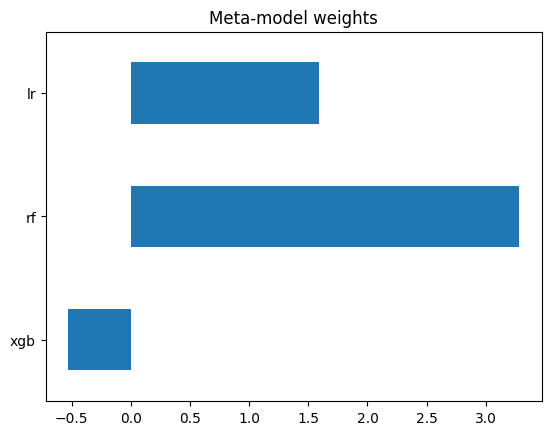

In [ ]:
meta = stack.final_estimator_

meta_weights = pd.Series(meta.coef_[0], index=stack.named_estimators_.keys())
meta_weights.plot(kind="barh", title="Meta-model weights")

Firstly, the models seem to have some interesting weights. The metalearner actually negatively weights the output of xgb, and heavily favors the random forest predictor. I think maybe some hyperparameter tuning for XGBoost would help a lot

In [ ]:

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)

param_grid = {
    'n_estimators': [400, 800, 1200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


## Future Improvements and Edits

Seasons expansion / data:
- I think it would be beneficial to expand the seasons I am using from just 10 (only ~ 560 games to train off of) to 20 or 30 seasons. This will just allow the models to get more data to actually train off of.
- May drop playoff games from being factored, as they are generally more unpredictable and can cause slight shifts in the data.

Feature analysis:
- May be interesting to see how well features actually matter when predicting games, and removing features that don't have much effect. This may add noise to the data that the model can't handle.

Hyperparameter Tuning:
- Seeing which different stratified k-fold n_folds parameters effect accuracy, if at all.

More Features:
- Features such as Avg QB rating, defensive efficiency, etc, could be interesting ones to add. 3rd Down conversion %s are really good indicators to have, but aren't included in this dataset. Maybe if I could use the pbp dataset to engineer that extra feature..